## Assignment

- Start a new notebook.
- Choose a Wikipedia page to forecast, and get the data.
- Begin with baselines for time series.
- Use the Prophet library to forecast pageviews for the Wikipedia page you chose. 
- Plot your forecast and share it on Slack.
- Commit your notebook to your fork of the GitHub repo.

### Stretch Challenges
- [Get daily weather station data](https://www.ncdc.noaa.gov/cdo-web/search) from the NOAA (National Oceanic and Atmospheric Administration). User Prophet to forecast the weather for your local area. 
- Adjust your forecasts with Prophet's [changepoints](https://facebook.github.io/prophet/docs/trend_changepoints.html) and [holidays](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html) options. In addition to Prophet's documentation, read Will Koehrsen's blog post, [Time Series Analysis in Python](https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a).
- Learn more about how Prophet works. Read the [tweestorm with animated GIFs](https://twitter.com/seanjtaylor/status/1123278380369973248) by Prophet developer Sean J. Taylor, or his [research paper](https://peerj.com/preprints/3190/).

In [1]:
import requests as r

https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews#Quick_start

In [3]:
page = 'Bitcoin' #page name
freq = 'daily' #daily or monthly
start = '2010123100' #yearmody00
end = '2019042300'
wiki_api = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents'

url = wiki_api+'/'+page+'/'+freq+'/'+start+'/'+end

In [4]:
req = r.get(url)

In [37]:
import pandas as pd
import numpy as np

In [6]:
json = req.json() #req is a request object
df = pd.DataFrame(json['items']) #json was a returned in dictionary format.

http://strftime.org/

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H') #%H = HR  (hour)

In [8]:
df.tail(1)

,access,agent,article,granularity,project,timestamp,views
1392,all-access,all-agents,Bitcoin,daily,en.wikipedia,2019-04-23,7817


In [9]:
df_clean = df.set_index('timestamp')
df_clean = df_clean[['views']]

start = '2015-07-01'
end = '2019-04-23'
future = '2019-12-31'
df_clean = df_clean.reindex(pd.date_range(start=start, end=future))
df_clean.tail(2)

,views
2019-12-30,NaN
2019-12-31,NaN


https://facebook.github.io/prophet/docs/quick_start.html#python-api

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [10]:
columns = ['timestamp', 'views']
df_prophet = df[columns]
df_prophet = df_prophet.rename(columns={'views': 'y', 'timestamp': 'ds'})

In [46]:
df_final = df_prophet.set_index('ds')

train = df_final['2015':'2017'].copy()
test = df_final['2018':'2019'].copy()

,y
ds,
2015-07-01,13137
2015-07-02,9938
2015-07-03,8498
2015-07-04,9113
2015-07-05,8908


### Prophet Forecasting

In [40]:
from fbprophet import Prophet

In [41]:
m = Prophet(daily_seasonality=False)
m.fit(train.reset_index())

train_forecast = m.predict(train.reset_index())[['ds','yhat']].set_index('ds')
test_forecast = m.predict(test.reset_index())[['ds','yhat']].set_index('ds')

/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


### Mean and Naive Forecasting

In [14]:
train['Mean_Baseline'] = train['y'].mean()
test['Mean_Baseline'] = train['y'].mean()

train['Naive_Baseline'] = train['y'].shift(1).bfill() #required to shift for MAE bfill = backwards fill
test['Naive_Baseline'] = train.iloc[-1]['Naive_Baseline']

### Mean Absolute Error (MAE) on forecasts

In [15]:
from sklearn.metrics import mean_absolute_error

train_mae = mean_absolute_error(train['y'], train['Mean_Baseline'])
test_mae = mean_absolute_error(test['y'], test['Mean_Baseline'])
print('Train MAE, for mean baseline:', train_mae)
print('Test MAE, for mean baseline:', test_mae)

train_mae = mean_absolute_error(train['y'], train['Naive_Baseline'])
test_mae = mean_absolute_error(test['y'], test['Naive_Baseline'])
print('Train MAE, for naive baseline:', train_mae)
print('Test MAE, for naive baseline:', test_mae)

train_mae = mean_absolute_error(train['y'], train_forecast['yhat'])
test_mae = mean_absolute_error(test['y'], test_forecast['yhat'])
print('Train MAE for Prophet (default params):', train_mae)
print('Test MAE for Prophet (default params):', test_mae)

Train MAE, for mean baseline: 17685.538360655737
Test MAE, for mean baseline: 12682.681082378765
Train MAE, for naive baseline: 4015.5333333333333
Test MAE, for naive baseline: 66647.87656903766
Train MAE for Prophet (default params): 10215.779595509912
Test MAE for Prophet (default params): 214877.89135032482


### Cross Validation

In [16]:
from fbprophet.diagnostics import cross_validation

In [50]:
m = Prophet(daily_seasonality=False)
m.fit(df_final.reset_index())
df_final.shape

/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


(1393, 1)

In [45]:
df_cv = cross_validation(m, initial='731 days', horizon='365 days' , period='60 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2017-08-26 00:00:00 and 2018-04-23 00:00:00
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/anaconda3/lib/python3.7/site-package

In [53]:
from fbprophet.diagnostics import performance_metrics
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,coverage
0,37 days,2.271732e+09,47662.691360,35285.523794,1.275000,0.300000
1,38 days,2.350498e+09,48481.930222,36252.680950,1.304418,0.283516
2,39 days,2.424565e+09,49239.872143,37171.371213,1.333523,0.261538
3,40 days,2.542748e+09,50425.670088,38283.814714,1.363604,0.245055
4,41 days,2.657645e+09,51552.349423,39341.461407,1.382504,0.228571
5,42 days,2.795855e+09,52875.846341,40462.946853,1.397308,0.212088
6,43 days,3.276691e+09,57242.384081,42231.256015,1.405583,0.202198
7,44 days,3.796619e+09,61616.709905,43860.340576,1.411124,0.200000
8,45 days,3.993173e+09,63191.558395,44913.454208,1.417716,0.196703
9,46 days,4.158451e+09,64486.055288,45997.132875,1.429384,0.196703


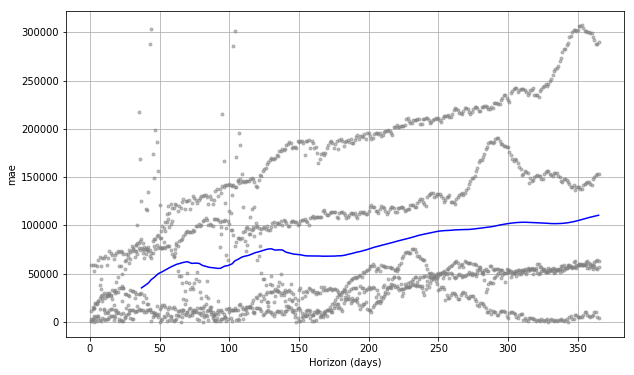

In [54]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')